# Simulating ACT: An investigation

## Preliminaries

Our goal is to simulate noise of an ACT patch such that:
1. anisotropy is captured
2. inhomogenity is captured
3. the PS of the sim calculated the same way as on the data agree

We start by assuming no point sources exist (no holes in mask).
We first spell out what is done to calculate (3).
We have 4 splits of the data $d_i$ .
We have an apodized analysis mask $m_A$ . (No holes, 1s everywhere except for apodized edge)
We have inverse variance maps $m_i$ .
We define the joint mask $m^J_i=m_A m_i$ . (The actual joint mask Steve uses might be more complicated, e.g. point source holes and cross-linking, but we start with this simple case)
The coadd map is defined by $d^C = \sum_i m_i d_i / m_C$ where $m_C = \sum_i m_i$.

We define a general power spectrum operator $P(d_\alpha,d_\beta,w_\alpha,w_\beta)$. The naive version is $P^N(d_\alpha,d_\beta,w_\alpha,w_\beta) = \rm{FFT}(d_\alpha)\rm{FFT}(d_\beta)^*/~\langle w_\alpha w_\beta \rangle$. The proper operator $P^M$ accounts for mode coupling, and we will investigate this later. The best estimator $P^S$ (wielded by Steve, DW, etc.) uses SHTs, applies a k-space filter, corrects mode coupling and applies a transfer function. The latter two only give us a binned view of the power. 



## Noise power estimator

The operator $P$ can be used to obtain an estimate of the noise power. If all the weights were uniform (and identical), there is an optimal estimator:
$$
\hat{N}^O_{\alpha\beta} = \frac{1}{n(n-1)}\sum_i P(d^\alpha_i-d^\alpha_C,d^\beta_i-d^\beta_C,m^A,m^A)
$$

We use a generalized version of this

$$
\hat{N}^{GO}_{\alpha\beta} = \frac{1}{n(n-1)}\sum_i P(d^\alpha_i-d^\alpha_C,d^\beta_i-d^\beta_C,m^J_{i\alpha},m^J_{i\beta})
$$


This can be compared to the sub-optimal estimator
$$
\hat{N}^S_{\alpha\beta} = P(d^C_\alpha,d^C_\beta,m^J_{C\alpha},m^J_{C\beta}) - \frac{2}{n(n-1)}\sum_{i>j} P(d^i_\alpha,d^j_\beta,m^J_{i\alpha},m^J_{j\beta})
$$

Yet another estimator is (this is what Alex has been using)

$$
\hat{N}^X_{\alpha\beta} = \frac{1}{n^2}\sum_i P(d^i_\alpha,d^i_\beta,m^J_{i\alpha},m^J_{i\beta}) - \frac{2}{n^2(n-1)}\sum_{i>j} P(d^i_\alpha,d^j_\beta,m^J_{i\alpha},m^J_{j\beta})
$$

**First, we compare all three of the above on Deep6 data.**

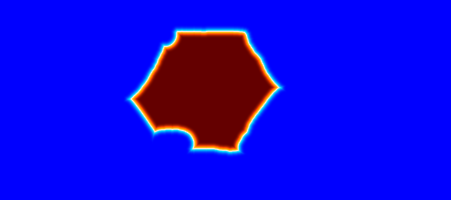

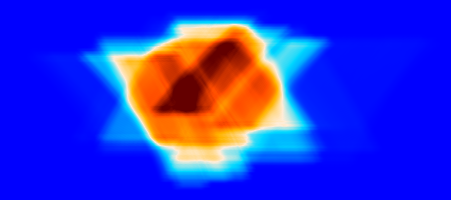

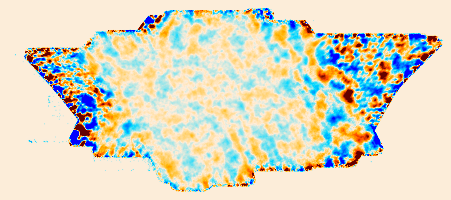

In [1]:
%load_ext autoreload
%autoreload 2
from pixell import enmap,enplot
import datamodel
import numpy as np
import matplotlib.pyplot as plt

# We load and visualize the data

plot = lambda imap : enplot.show(enplot.plot(enmap.downgrade(imap,8),grid=False))
dm = datamodel.DataModel("s13","pa1","deep6")
modlmap = enmap.modlmap(dm.shape,dm.wcs)
plot(dm.mask_a)
plot(dm.get_inv_var()[0][0][0])
plot(dm.get_map()[0][0][0])

In [2]:

"""
Here we set up a Power object that can eventually plug in to a mode coupling code.
We will only work with scalar (spin-0) spectra since our goal is to look at II,QQ,UU,IQ,IU,QU.
"""

from powtools import Power, get_coadd   
    
pobj = Power(dm.shape,dm.wcs,mc=False)

In [3]:
# We have to do the noise power calculation on an array by array basis, where each array points to some freq and I/Q/U. So for PA3 for example, there will be a loop over the following with 6*(6+1)/2 runs

ifreq = 0 # only one frequency for PA1
ipol = 0 # only doing TT for now

splits = dm.get_map()[ifreq,:,ipol]
wts = dm.get_inv_var()[ifreq,:,ipol]

coadds,cweights = get_coadd(splits,wts)


/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


In [4]:
# We look at the noise power
# sub-optimal
p2d = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,estimator='suboptimal')
# X estimator (Alex-style)
p2dS = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,estimator='alex')
# Generalized optimal estimator
p2dO = pobj.noise_power(coadds,cweights*dm.mask_a,splits,wts*dm.mask_a,estimator='optimal')

/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


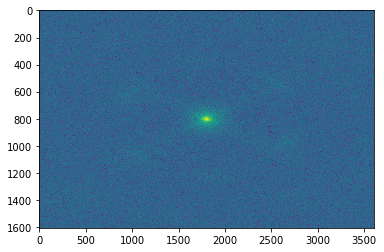

In [5]:
# X estimator (Alex)
plt.imshow(np.fft.fftshift(np.log10(p2dS)),aspect='auto')

**This looks nice.**

/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


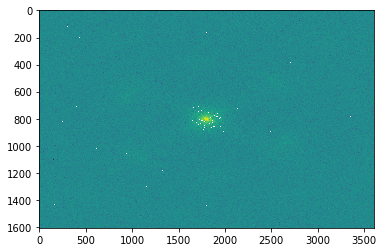

In [6]:
# Sub-optimal estimator
plt.imshow(np.fft.fftshift(np.log10(p2d)),aspect='auto')

#### We see unphysical negative power fluctuations in the sub-optimal estimator.

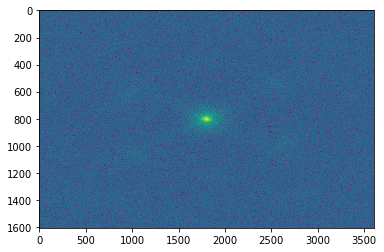

In [7]:
# Optimal estimator
plt.imshow(np.fft.fftshift(np.log10(p2dO)),aspect='auto')

**This also looks nice.**

In [8]:
bin_edges = np.arange(80,8000,80)
cents,p1d = datamodel.binned_power(p2d,modlmap,bin_edges)
cents,p1dS = datamodel.binned_power(p2dS,modlmap,bin_edges)
cents,p1dO = datamodel.binned_power(p2dO,modlmap,bin_edges)

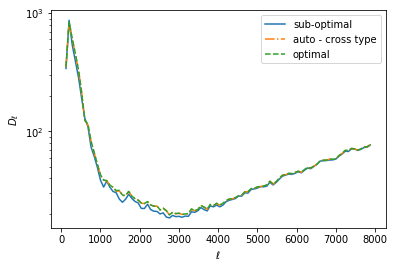

In [9]:
plt.plot(cents,p1d*cents**2./2./np.pi,label='sub-optimal')
plt.plot(cents,p1dS*cents**2./2./np.pi,ls="-.",label='auto - cross type')
plt.plot(cents,p1dO*cents**2./2./np.pi,ls="--",label="optimal")
plt.legend()
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('log')

#### We see considerable difference in power between the optimal estimator and the sub-optimal one at intermediate scales.

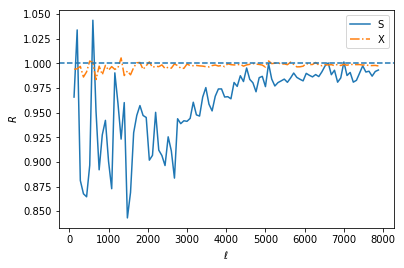

In [10]:
plt.plot(cents,p1d/p1dO,label='S')
plt.plot(cents,p1dS/p1dO,ls="-.",label='X')
plt.legend()
plt.axhline(y=1,ls="--")
plt.xlabel("$\\ell$")
plt.ylabel("$R$")
plt.xscale('linear')
plt.yscale('linear')

The optimal and (ale)X estimators are only 0.5% different, so we stick to the optimal one and consistently use it on the data and on the sims. **We have however learned the important lesson that the choice of noise PS estimator can lead to 15% differences.** 

## Moving to IQU

We loop over polarization components.

In [11]:

from powtools import get_n2d

def get_n2d_data(season,array,patch,flattened=False):
    dm = datamodel.DataModel(season,array,patch)
    smaps = dm.get_map()
    wmaps = dm.get_inv_var()
    return get_n2d(pobj,smaps,wmaps,dm.mask_a,flattened=flattened)
    
    

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


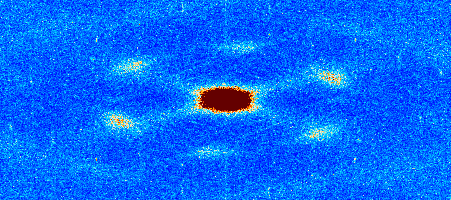

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


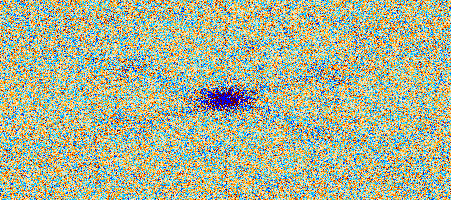

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


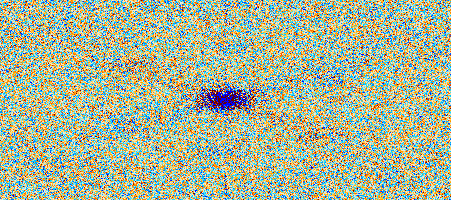

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


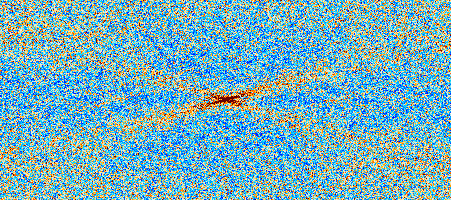

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


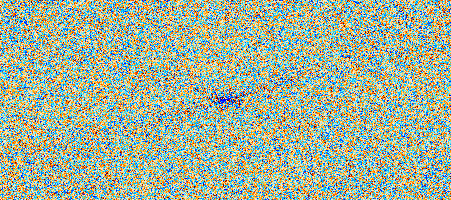

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


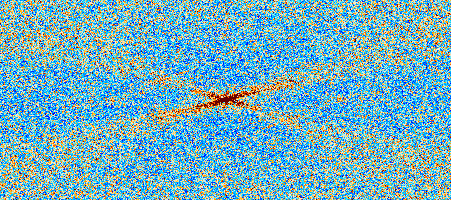

In [12]:
n2d_data_saved = get_n2d_data("s13","pa1","deep6")

## Flattened spectra

We now calculate flattened spectra from which GRFs are generated. These are created by multiplying all maps by sqrt(inv var).

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


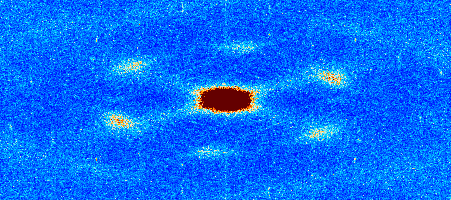

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


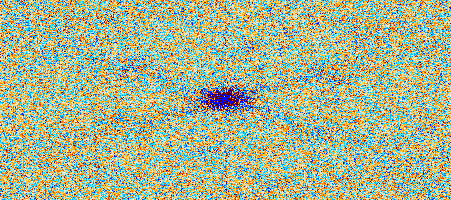

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


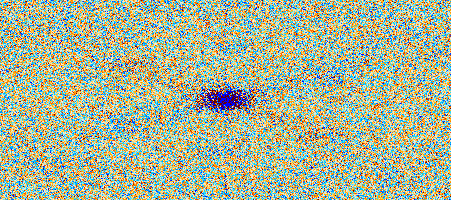

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


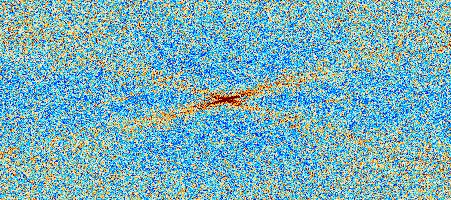

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


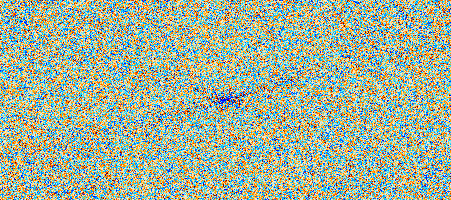

/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


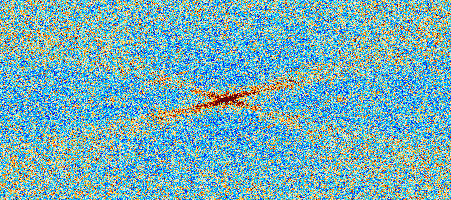

In [13]:
#season,array,patch = "s13","pa1","deep1"
season,array,patch = "s13","pa1","deep6"
#season,array,patch = "s15","pa3","deep56"

dm = datamodel.DataModel(season,array,patch)
modlmap = enmap.modlmap(dm.shape,dm.wcs)

n2d_flat = get_n2d_data(season,array,patch,flattened=True)


/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


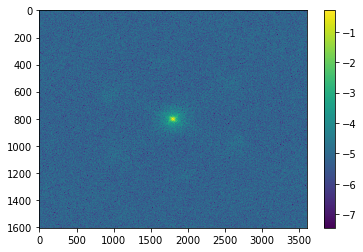

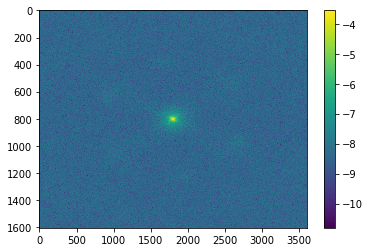

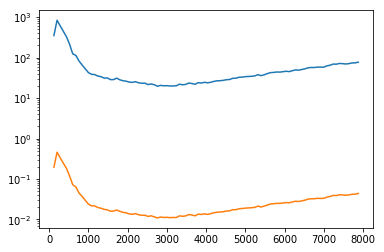

In [14]:
ftrans = lambda x: np.log10(np.fft.fftshift(x))
def mshow(img):
    plt.imshow(ftrans(img),aspect='auto')
    plt.colorbar()
    plt.show()
mshow(n2d_data_saved[0,0])
mshow(n2d_flat[0,0])

cents,p1d = datamodel.binned_power(n2d_data_saved[0,0],modlmap,bin_edges)
cents,p1df = datamodel.binned_power(n2d_flat[0,0],modlmap,bin_edges)
plt.plot(cents,p1d*cents**2./2./np.pi)
plt.plot(cents,p1df*cents**2./2./np.pi)
plt.yscale('log')
plt.show()

## Smoothing

We save noises that have and do not have smoothing.

/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: divide by zero encountered in true_divide
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.
/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: overflow encountered in multiply
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.


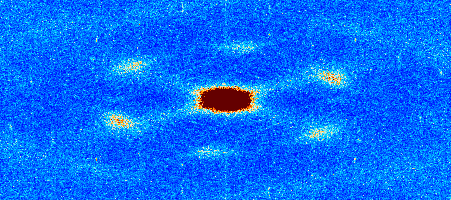

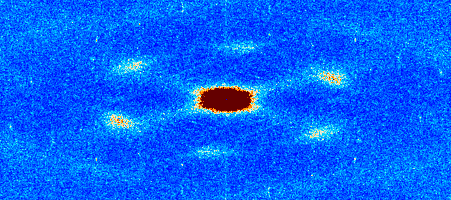

/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: divide by zero encountered in true_divide
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.
/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: overflow encountered in multiply
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.


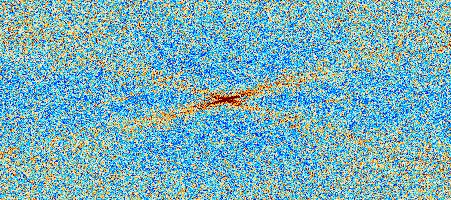

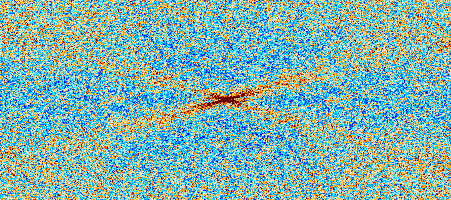

/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: divide by zero encountered in true_divide
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.
/home/msyriac/repos/tilec/tilec/covtools.py:46: RuntimeWarning: overflow encountered in multiply
  atm_factor = (lknee*np.nan_to_num(1./ells))**(-alpha) if lknee>1.e-3 else 0.


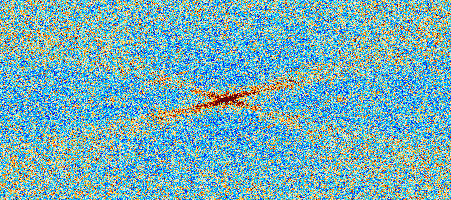

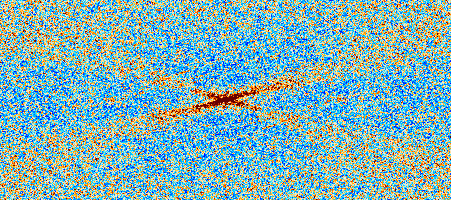

/home/msyriac/repos/actsims/notebooks/powtools.py:228: RuntimeWarning: invalid value encountered in sqrt
  mul = np.sqrt(sps[i,i]*sps[j,j])


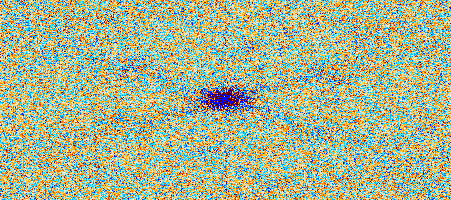

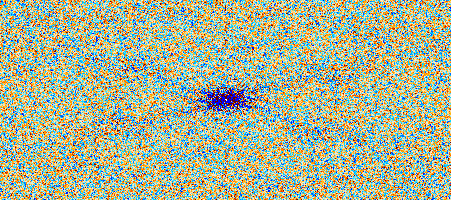

/home/msyriac/repos/actsims/notebooks/powtools.py:228: RuntimeWarning: invalid value encountered in sqrt
  mul = np.sqrt(sps[i,i]*sps[j,j])


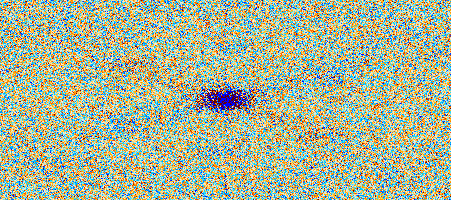

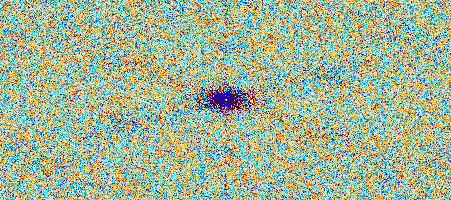

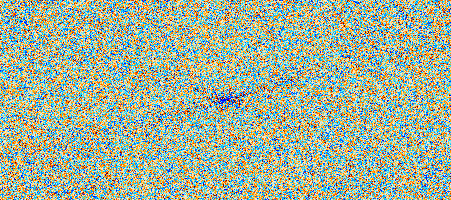

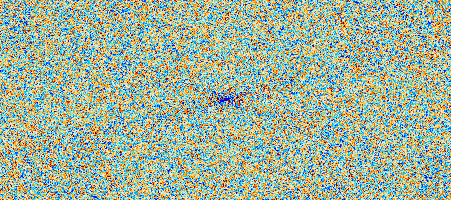

In [32]:
from powtools import smooth_ps
dfact=(8,8)
n2d_flat_smoothed = smooth_ps(n2d_flat.copy(),dfact=dfact,radial_pairs=[(0,0),(1,1),(2,2),(3,3),(4,4),(5,5),(0,3)])

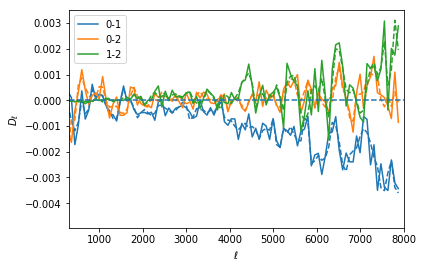

In [33]:
# Compare the off diagonals
ncomps = n2d_flat.shape[0]
k = 0
for i in range(ncomps):
    for j in range(i,ncomps):
        if i==j or (i==0 and j==3) or (i==3 and j==0): continue

        cents,p1d = datamodel.binned_power(n2d_flat[i,j],modlmap,bin_edges)
        cents,p1dS = datamodel.binned_power(n2d_flat_smoothed[i,j],modlmap,bin_edges)
        plt.plot(cents,p1d*cents**2./2./np.pi,label="%d-%d" % (i,j),color="C%d" % k)
        plt.plot(cents,p1dS*cents**2./2./np.pi,ls="--",color="C%d" % k)
        k = k+1
plt.legend()
plt.xlim(300,8000)
plt.axhline(y=0,ls="--")
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('linear')




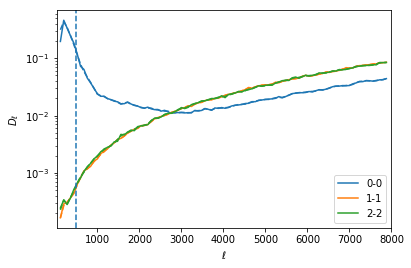

In [34]:

ncomps = n2d_flat.shape[0]
k = 0
for i in range(ncomps):
    for j in range(i,ncomps):
        if not(i==j or (i==0 and j==3) or (i==3 and j==0)): continue

        cents,p1d = datamodel.binned_power(n2d_flat[i,j],modlmap,bin_edges)
        cents,p1dS = datamodel.binned_power(n2d_flat_smoothed[i,j],modlmap,bin_edges)
        plt.plot(cents,p1d*cents**2./2./np.pi,label="%d-%d" % (i,j),color="C%d" % k)
        plt.plot(cents,p1dS*cents**2./2./np.pi,ls="--",color="C%d" % k)
        k = k+1
plt.legend()
plt.xlim(30,8000)
plt.axvline(x=500,ls="--")
plt.xlabel("$\\ell$")
plt.ylabel("$D_{\\ell}$")
plt.xscale('linear')
plt.yscale('log')



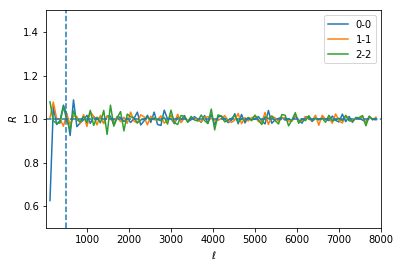

In [35]:
ncomps = n2d_flat.shape[0]
for i in range(ncomps):
    for j in range(i,ncomps):
        if i==j or (i==0 and j==3) or (i==3 and j==0):
            cents,p1d = datamodel.binned_power(n2d_flat[i,j],modlmap,bin_edges)
            cents,p1dS = datamodel.binned_power(n2d_flat_smoothed[i,j],modlmap,bin_edges)
            plt.plot(cents,p1d/p1dS,label="%d-%d" % (i,j))
plt.legend()
plt.xlim(30,8000)
plt.axvline(x=500,ls="--")
plt.ylim(0.5,1.5)
plt.axhline(y=1,ls="--")
plt.xlabel("$\\ell$")
plt.ylabel("$R$")
plt.xscale('linear')
plt.yscale('linear')

## Covsqrt

We explore 6 different ways of square rooting the covariance matrix:
1. Multipow (with correlations)
2. Arrayops (with correlations)
3. Multipow (no correlations)
4. Arrayops (no correlations)
5. Multipow (I-I correlations)
6. Arrayops (I-I correlations)

The last two only apply to PA3. Together with smoothed and unsmoothed, this presents 12 possible combinations.

In [ ]:

def null_off_diagonals(cov):
    ocov = cov.copy()
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            if i==j: continue
            ocov[i,j] = 0
    return ocov
    
def null_pol_off_diagonals(cov):
    ocov = cov.copy()
    for i in range(cov.shape[0]):
        for j in range(cov.shape[0]):
            if i==j or (i==0 and j==3) or (i==3 and j==0): continue
            ocov[i,j] = 0
    return ocov
    
def get_covsqrt(ps,method="multipow"):
    if method=="multipow":
        return enmap.multi_pow(ps.copy(),0.5)
    elif method=="arrayops":
        from enlib import array_ops
        return array_ops.eigpow(ps.copy(),0.5,axes=[0,1])

In [20]:
from enlib import bench

for method in ['multipow']:#,'arrayops']:
    with bench.show(method):
        covsqrt = get_covsqrt(n2d_flat,method)

20.55  5.39  6.78 multipow


## Sim generation

In [36]:
def binary_mask(mask,threshold=0.5):
    m = np.abs(mask)
    m[m<threshold] = 0
    m[m>threshold] = 1
    return m

def generate_noise_sim(season,array,patch,icovsqrt,binary_percentile=10.,seed=None):
    if isinstance(seed,int): seed = [seed]
        
    dm = datamodel.DataModel(season,array,patch)
    modlmap = enmap.modlmap(dm.shape,dm.wcs)
    Ny,Nx = dm.shape[-2:]
    nfreqs = dm.nfreqs
    ncomps = nfreqs * 3
    wmaps = dm.get_inv_var()
    wcs = wmaps.wcs
    
    nsplits = wmaps.shape[1]
    
    covsqrt = icovsqrt 
    kmap = []
    for i in range(nsplits):
        if seed is None:
            np.random.seed(None)
        else:
            np.random.seed(seed+[i])
        rmap = enmap.rand_gauss_harm((ncomps, Ny, Nx),covsqrt.wcs) 
        kmap.append( enmap.map_mul(covsqrt, rmap) )
    kmap = enmap.enmap(np.stack(kmap),dm.wcs)
    outmaps = enmap.ifft(kmap, normalize="phys").real
    
    
    fmaps = []
    for ifreq in range(nfreqs):
        omaps = outmaps[:,ifreq*3:(ifreq+1)*3,...].copy() / np.sqrt(wmaps[ifreq,...]) *np.sqrt(nsplits)
        fmaps.append(omaps.copy())
    fmaps = enmap.enmap(np.stack(fmaps),dm.wcs)
    del omaps,outmaps
    
    # Sanitize
    for ifreq in range(nfreqs):
        for isplit in range(nsplits):
            win = wmaps[ifreq,isplit,0,...]
            bmask = binary_mask(win,threshold = np.percentile(win,binary_percentile))
            fmaps[...,bmask==0] = 0
            
    return fmaps



/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide


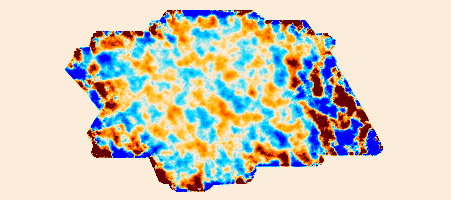

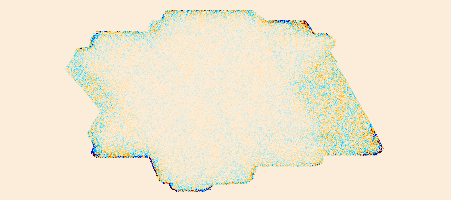

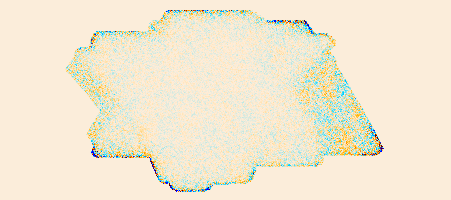

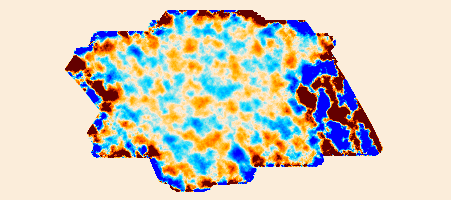

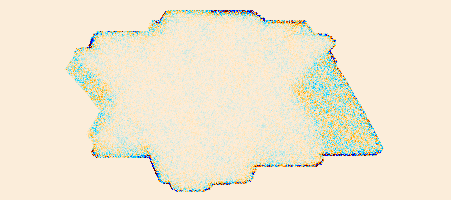

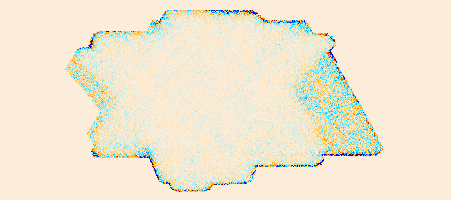

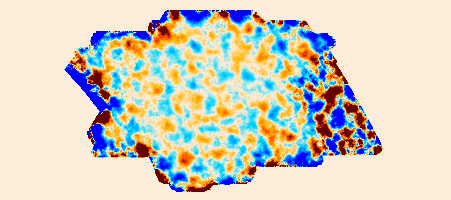

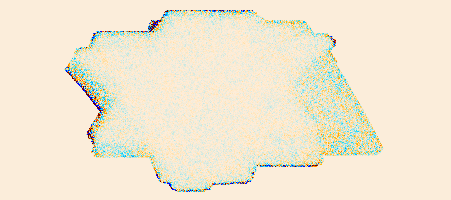

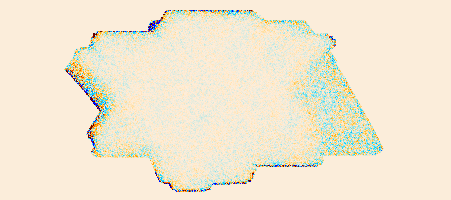

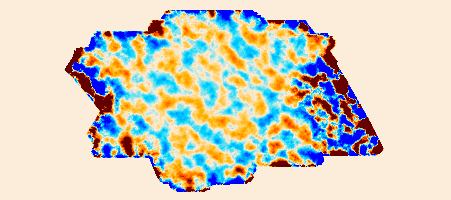

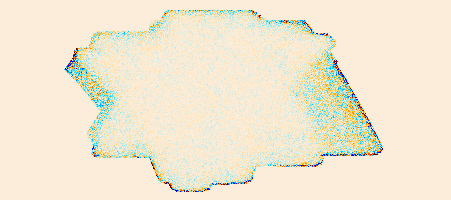

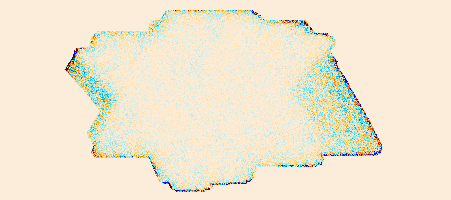

In [22]:
sims = generate_noise_sim(season,array,patch,covsqrt,seed=100)
plot(sims)

## Naive PS comparison

Do we get things to make sense on Deep6 PA1?

smoothed   arrayops   all-corrs


/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


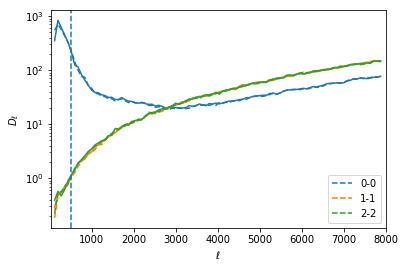

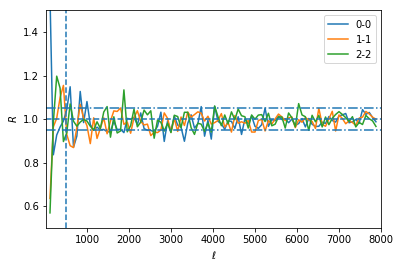

unsmoothed   arrayops   all-corrs


/home/msyriac/.local/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/msyriac/repos/actsims/notebooks/powtools.py:135: RuntimeWarning: invalid value encountered in true_divide
  return np.nan_to_num(np.sum(wts*imaps,axis=0)/twt),twt


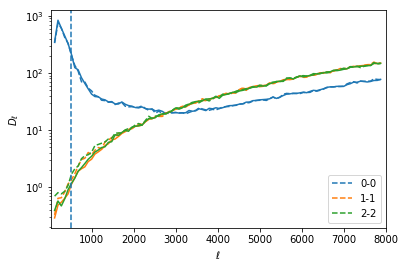

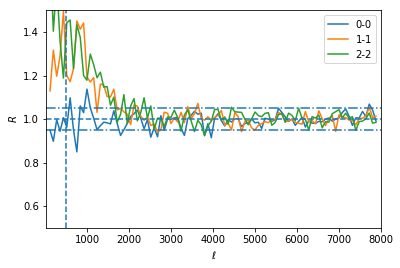

smoothed   multipow   all-corrs


LinAlgError: Eigenvalues did not converge

In [38]:
seed = 100
dm = datamodel.DataModel(season,array,patch)
wmaps = dm.get_inv_var()

p1ds_data = np.zeros((n2d_data_saved.shape[0],n2d_data_saved.shape[0],bin_edges.size-1))
for i in range(n2d_data_saved.shape[0]):
    for j in range(n2d_data_saved.shape[0]):
        p1ds_data[i,j] = datamodel.binned_power(n2d_data_saved[i,j],modlmap,bin_edges)[1]
        
cents = (bin_edges[1:] + bin_edges[:-1])/2.
        
# multipow can have linalg failures
# n2d_sim should be compared to n2d_data_saved
for corrfunc,corrlabel in zip([lambda x: x,null_off_diagonals,null_pol_off_diagonals][:2],
                              ['all-corrs','no-off','no-pol-off'][:2]):
    #for method in ['multipow','arrayops'][::-1]:
    for method in ['arrayops']:
        for n2d,smlabel in zip([n2d_flat,n2d_flat_smoothed][::-1],['unsmoothed','smoothed'][::-1]):
            print(smlabel," ",method," ",corrlabel)
            covsqrt = get_covsqrt(corrfunc(n2d),method)
            sims = generate_noise_sim(season,array,patch,covsqrt,seed=seed)
            n2d_sim = get_n2d(pobj,sims,wmaps,dm.mask_a,flattened=False,show=False)

            k = 0
            p1ds = np.zeros((n2d_sim.shape[0],n2d_sim.shape[0],bin_edges.size-1))
            for i in range(n2d_sim.shape[0]):
                for j in range(n2d_sim.shape[0]):
                    if not(i==j or (i==0 and j==3) or (i==3 and j==0)): continue
                    p1ds[i,j] = datamodel.binned_power(n2d_sim[i,j],modlmap,bin_edges)[1]
                    plt.plot(cents,p1ds[i,j]*cents**2./2./np.pi,label="%d-%d" % (i,j),color="C%d" % k,ls="--")
                    plt.plot(cents,p1ds_data[i,j]*cents**2./2./np.pi,color="C%d" % k)
                    k = k+1
            plt.legend()
            plt.xlim(30,8000)
            plt.axvline(x=500,ls="--")
            plt.xlabel("$\\ell$")
            plt.ylabel("$D_{\\ell}$")
            plt.xscale('linear')
            plt.yscale('log')
            plt.show()
            
            k = 0
            for i in range(n2d_sim.shape[0]):
                for j in range(n2d_sim.shape[0]):
                    if not(i==j or (i==0 and j==3) or (i==3 and j==0)): continue
                    plt.plot(cents,p1ds[i,j]/p1ds_data[i,j],label="%d-%d" % (i,j),color="C%d" % k)
                    k = k+1
            plt.legend()
            plt.xlim(30,8000)
            plt.ylim(0.5,1.5)
            plt.axvline(x=500,ls="--")
            plt.axhline(y=1,ls="--")
            plt.axhline(y=1.05,ls="-.")
            plt.axhline(y=0.95,ls="-.")
            plt.xlabel("$\\ell$")
            plt.ylabel("$R$")
            plt.xscale('linear')
            plt.yscale('linear')
            plt.show()                        

## The PA3 behemoth

Let's do the loop on PA3.

## Adding mode coupling

Assuming that the Power class has been completed, we can now loop in mode coupling to make sure that doesn't change anything.